In [1]:
import torch
import numpy as np
import glob
import os
from fastai.data.core import DataLoaders
import random
import torch.nn.functional as F
from fastai.vision.all import *

In [2]:
class DataLoaderSegmentation(torch.utils.data.Dataset):
    def __init__(self, folder_path):
        super(DataLoaderSegmentation, self).__init__()
        self.img_files = glob.glob(os.path.join(folder_path,'features','*.npy'))
        self.mask_files = []
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(folder_path,'masks',os.path.basename(img_path)) )

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            
            data = np.load(img_path)
            label = np.load(mask_path)
            
            data = torch.from_numpy(data).float()
            label = torch.from_numpy(label).float()
            
            return F.interpolate(data.unsqueeze(0), (128, 128)).squeeze(0), F.interpolate(label.unsqueeze(0), (128, 128)).squeeze(0)

    def __len__(self):
        return len(self.img_files)

In [3]:
ds_train = DataLoaderSegmentation(os.path.join('data', 'yeast_processed_norm', 'train'))
ds_test = DataLoaderSegmentation(os.path.join('data', 'yeast_processed_norm', 'test'))

In [4]:
ds_train.__len__(), ds_test.__len__()

(1445, 161)

In [5]:
ds_train.__getitem__(0)

(tensor([[[2.9338e-02, 2.9338e-02, 1.4756e-02,  ..., 2.3349e-02,
           1.6318e-02, 1.8401e-02],
          [2.9338e-02, 2.9338e-02, 1.4756e-02,  ..., 2.3349e-02,
           1.6318e-02, 1.8401e-02],
          [1.4756e-02, 1.4756e-02, 3.5414e-02,  ..., 1.8141e-02,
           2.6126e-02, 2.5519e-02],
          ...,
          [2.3349e-02, 2.3349e-02, 1.8141e-02,  ..., 8.1069e-02,
           1.8228e-02, 1.9009e-02],
          [1.6318e-02, 1.6318e-02, 2.6126e-02,  ..., 1.8228e-02,
           2.8991e-02, 2.3956e-02],
          [1.8401e-02, 1.8401e-02, 2.5519e-02,  ..., 1.9009e-02,
           2.3956e-02, 2.1795e-01]],
 
         [[1.3212e-04, 1.3212e-04, 2.6424e-04,  ..., 1.1230e-02,
           1.1362e-02, 1.1494e-02],
          [1.3212e-04, 1.3212e-04, 2.6424e-04,  ..., 1.1230e-02,
           1.1362e-02, 1.1494e-02],
          [2.6424e-04, 2.6424e-04, 5.2847e-04,  ..., 2.2460e-02,
           2.2724e-02, 2.2989e-02],
          ...,
          [1.1230e-02, 1.1230e-02, 2.2460e-02,  ..., 9.545

In [6]:
ds_train.__getitem__(0)[0].shape, ds_train.__getitem__(0)[1].shape

(torch.Size([4, 128, 128]), torch.Size([1, 128, 128]))

In [7]:
torch.unique(ds_train.__getitem__(0)[1])

tensor([0., 1.])

In [8]:
dls = DataLoaders.from_dsets(ds_train, ds_test, bs=4, num_workers=0)

In [9]:
dls.one_batch()[0].shape

torch.Size([4, 4, 128, 128])

In [10]:
dls.cuda()

In [11]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [11]:
learn = unet_learner(dls, models.resnet34, loss_func=BCELossFlat(axis=1), n_in=4, n_out=1, wd=1e-2, y_range=(0,1))

In [12]:
torch.cuda.set_device(0)
torch.cuda.get_device_name(0)
torch.set_num_threads(1)
learn.model
learn.model.cuda()

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [13]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

SuggestedLRs(lr_min=0.00014454397605732084, lr_steep=0.0063095735386013985)

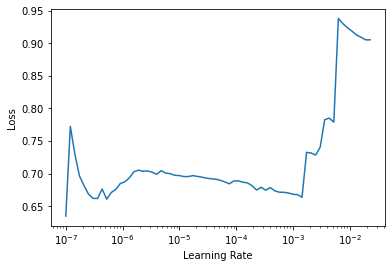

In [16]:
learn.freeze()
learn.lr_find()
# learn.recorder.plot()

In [18]:
learn.fit_one_cycle(1, slice(5e-4), pct_start=0.9)

epoch,train_loss,valid_loss,time
0,0.609103,0.584013,00:35


SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=1.0964781722577754e-06)

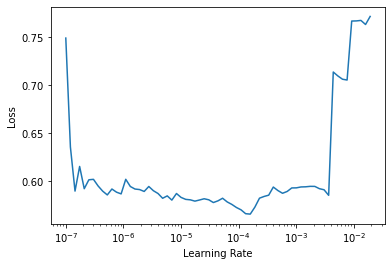

In [19]:
learn.unfreeze()
learn.lr_find()

In [20]:
learn.fit_one_cycle(25, slice(1e-4), pct_start=0.9)

epoch,train_loss,valid_loss,time
0,0.570988,0.579008,00:35
1,0.580182,0.575435,00:34
2,0.563802,0.570085,00:33
3,0.566370,0.560382,00:34
4,0.550747,0.548897,00:35
5,0.542035,0.536624,00:34
6,0.529810,0.525172,00:34
7,0.494694,0.540980,00:34
8,0.490550,0.614546,00:34
9,0.470835,0.594336,00:34


In [38]:
print(fastai.__version__ ) 

2.1.8
